In [1]:
!pip install tensorflow tensorflow_hub matplotlib

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


In [2]:
(train_ds, validation_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:85%]', 'train[15%:]'],
    with_info=True,
    as_supervised=True,
)

print(ds_info)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1.incomplete5UF3B4',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/examp

In [3]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize images
    image = image / 255.0  # Normalize pixel values
    return image, label

train_batches = train_ds.shuffle(1000).map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
validation_batches = validation_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)


In [4]:
URL = "https://tfhub.dev/google/bit/m-r50x1/1"
feature_extractor_layer = hub.KerasLayer(URL, input_shape=(224, 224, 3), trainable=False)

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])


In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_batches, epochs=2, validation_data=validation_batches)


Epoch 1/2
98/98 [==============================] - 1675s 17s/step - loss: 0.2283 - accuracy: 0.9381 - val_loss: 0.0850 - val_accuracy: 0.9731
Epoch 2/2
98/98 [==============================] - 1688s 17s/step - loss: 0.0973 - accuracy: 0.9699 - val_loss: 0.1052 - val_accuracy: 0.9692


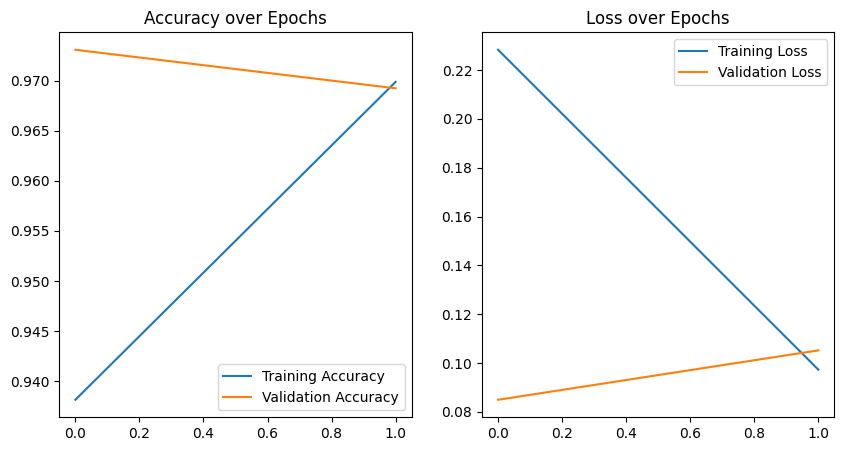

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()


1/1 [==============================] - 10s 10s/step


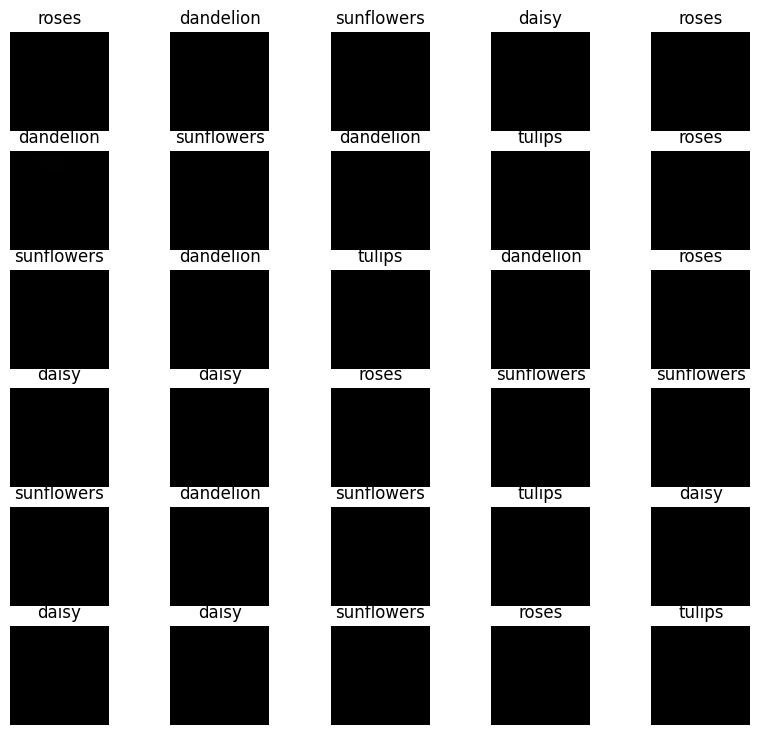

In [8]:
import numpy as np

# Get a batch of images from the validation set
image_batch, label_batch = next(iter(validation_batches))

# Predict
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_labels = ds_info.features['label'].names

# Plot the results
plt.figure(figsize=(10, 9))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(predicted_labels[predicted_id[i]])
    plt.axis("off")


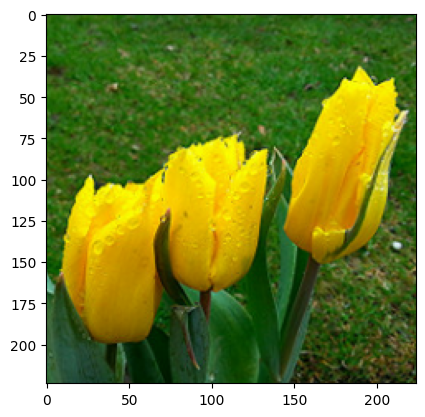

In [9]:
# Ensure the image is scaled to [0, 255] and typecast to uint8
plt.imshow((image_batch[i].numpy() * 255).astype(np.uint8))


In [10]:
print(image_batch[0])  # Print the first image in the batch to check its pixel values


tf.Tensor(
[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.00390156 0.00616247]
  [0.02593035 0.06430569 0.01332531]
  [0.01391556 0.08413363 0.00065027]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.00225089 0.00645257 0.00691276]
  [0.04273702 0.08251293 0

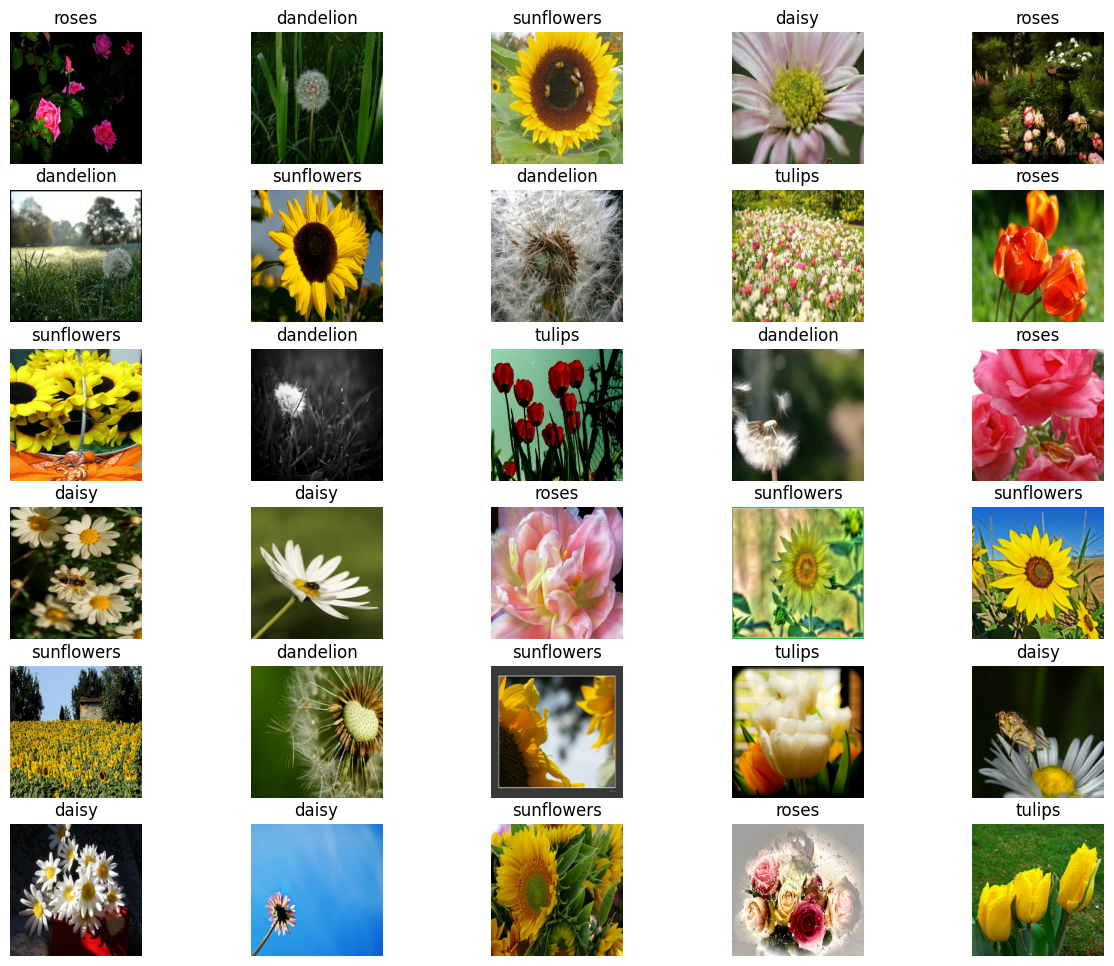

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))  # Increase figure size for better visibility
for i in range(30):  # Assuming you have at least 30 images in the batch
    ax = plt.subplot(6, 5, i + 1)
    img = image_batch[i].numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1] for display
    plt.imshow(img)
    plt.title(predicted_labels[predicted_id[i]])
    plt.axis("off")
plt.show()
